### This is based on pytorch tutorial:
https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

#### Install pycocotools, the version by default in Colab has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354

In [2]:
%%shell

pip install cython
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-hf8k6cs8
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-hf8k6cs8
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=263919 sha256=98a1b3c60517de7f81f46262c167e940c5389728e1c3f838dc11a9581bde39e1
  Stored in directory: /tmp/pip-ephem-wheel-cache-4bl1znvv/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0.2
    Uninstalling pycocotools-2.0.2:
      Successfully uninstalled pycocotools-2.0.2


## Defining the Dataset


* image: a PIL Image of size (H, W)
* target: a dict containing the following fields
    * `boxes` (`FloatTensor[N, 4]`): the coordinates of the `N` bounding boxes in `[x0, y0, x1, y1]` format, ranging from `0` to `W` and `0` to `H`
    * `labels` (`Int64Tensor[N]`): the label for each bounding box
    * `image_id` (`Int64Tensor[1]`): an image identifier. It should be unique between all the images in the dataset, and is used during evaluation
    * `area` (`Tensor[N]`): The area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.
    * `iscrowd` (`UInt8Tensor[N]`): instances with `iscrowd=True` will be ignored during evaluation.


### Writing a custom dataset for Penn-Fudan

First, let's download and extract the data, present in a zip file at https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip

In [3]:
%%shell

# download the Penn-Fudan dataset
wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .
# extract it in the current folder
unzip PennFudanPed.zip

--2021-03-22 20:09:21--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M  32.3MB/s    in 1.6s    

2021-03-22 20:09:24 (32.3 MB/s) - ‘PennFudanPed.zip’ saved [53723336/53723336]

--2021-03-22 20:09:24--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2021-03-22 20:09:24--
Total wall clock time: 2.7s
Downloaded: 1 files, 51M in 1.6s (32.3 MB/s)
Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: Pen

Let's have a look at the dataset and how it is layed down.

The data is structured as follows
```
PennFudanPed/
  PedMasks/
    FudanPed00001_mask.png
    FudanPed00002_mask.png
    FudanPed00003_mask.png
    FudanPed00004_mask.png
    ...
  PNGImages/
    FudanPed00001.png
    FudanPed00002.png
    FudanPed00003.png
    FudanPed00004.png
```

Here is one example of an image in the dataset, with its corresponding instance segmentation mask

In [4]:
import cv2
import numpy as np
class ImageDirtier():
  def __init__(self,number_of_spots,minimal_size,maximal_size):
    self.number_of_spots = number_of_spots
    self.minimal_size = minimal_size
    self.maximal_size = maximal_size
    self.minimal_transparency = 0.8
    self.maximal_transparency = 0.9
    self.lod = 7

  def to_radians(self,angle):
    return angle * np.pi / 180.0

  def point_on_circle(self,center_point,angle,radius):
    x = center_point[0] + radius * np.cos(self.to_radians(angle))
    y = center_point[1] + radius * np.sin(self.to_radians(angle))
    return np.array([x,y])

  def minmax(self,number,limit):
    return max(0,min(number,limit))
  
  def generate_polygons(self,width,height):
    polygons = np.zeros((self.number_of_spots, self.lod, 3))
    for i in range(self.number_of_spots):
      angle = 0
      move_angle = 360 / self.lod
      main_radius = np.random.uniform(self.minimal_size, self.maximal_size)
      center_point = np.random.randint([0 + main_radius, 0 + main_radius],[width - main_radius, height - main_radius])
      bonus = 0
      for j in range(self.lod):
        move = np.random.randint(0,move_angle + bonus)
        diff_radius = np.random.uniform(main_radius / 6,main_radius / 2)
        bonus += move_angle - move
        angle += move
        new_point = self.point_on_circle(center_point, angle, main_radius - diff_radius)
        polygons[i][j] = np.array([self.minmax(new_point[0], width),self.minmax(new_point[1], height), 1],dtype = np.int)
    return polygons
  
  def parse_polygons(self,polygons):
    polygons_contours = []
    for i in range(polygons.shape[0]):
      polygons_contours.append([])
      transformed_polygon = []
      for j in range(polygons.shape[1]):
        transformed_polygon.append([polygons[i][j][0], polygons[i][j][1]])
      polygons_contours[i].append(np.array(transformed_polygon, dtype = np.int))
    return polygons_contours

  def apply_spots(self,image, contours):
    mask = np.zeros(image.shape[:2])
    img2 = np.copy(image)
    for i, contour in enumerate(contours):
      cv2.drawContours(mask, contour, 0, 255*(i+1), -1)
      color = np.random.uniform(0,16)
      cv2.drawContours(img2, contour, 0, (color, color, color), -1)
    transparency = np.random.uniform(self.minimal_transparency, self.maximal_transparency)
    img2 = cv2.addWeighted(image, transparency, img2, 1 - transparency, 0, img2)
    return img2,mask/255.
  
  def apply(self,image):
    polygons = self.generate_polygons(image.shape[0], image.shape[1])
    polygons_contours = self.parse_polygons(polygons)
    return self.apply_spots(image, polygons_contours)

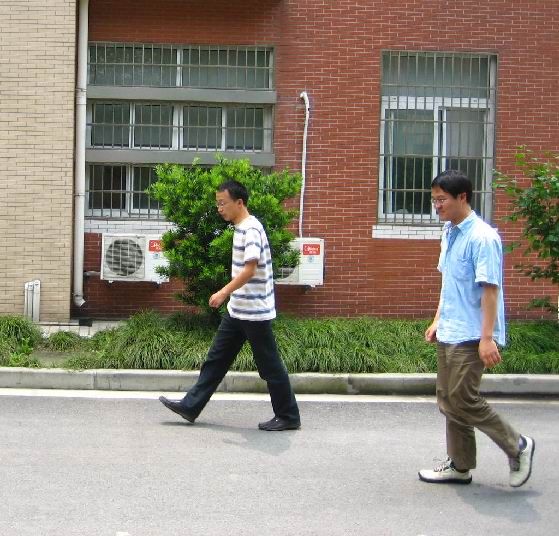

In [5]:
from PIL import Image
Image.open('PennFudanPed/PNGImages/FudanPed00001.png')

In [24]:
img_dirtier = ImageDirtier(15,5,10)
image = Image.open('PennFudanPed/PNGImages/FudanPed00001.png')
img, mask = img_dirtier.apply(np.array(image))

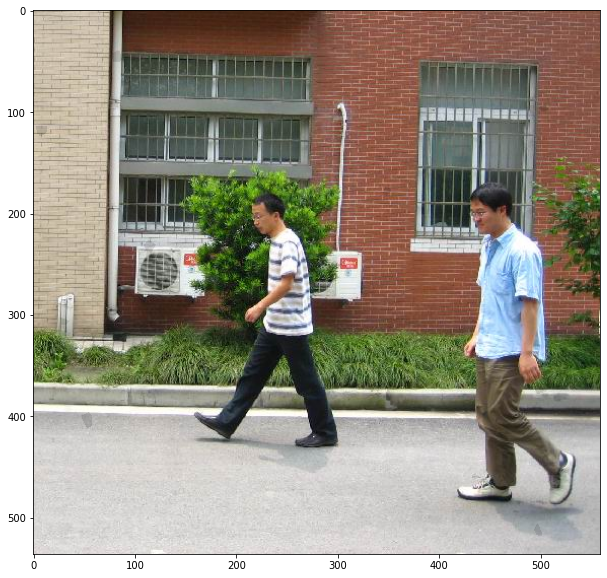

(536, 559)


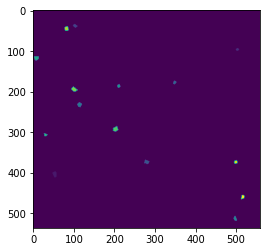

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize = (20,10))
plt.imshow(img)
plt.show()
print(mask.shape)
plt.imshow(mask)

So each image has a corresponding segmentation mask, where each color correspond to a different instance. Let's write a `torch.utils.data.Dataset` class for this dataset.

In [8]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
      self.root = root
      self.transforms = transforms
      # load all image files, sorting them to
      # ensure that they are aligned
      self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
      self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))
      self.dirt_spots_creator = ImageDirtier(number_of_spots = 15, minimal_size = 5, maximal_size = 10)

    def merge_masks(self, under_mask, upper_mask, start):
      ret_mat = np.where(upper_mask != 0,upper_mask,under_mask)
      return np.where(ret_mat == start,0,ret_mat)

    def reduce_mask(self, mask):
      obj_ids = np.unique(mask)
      obj_ids = obj_ids[1:]
      num_obj = len(obj_ids)
      masks = mask == obj_ids[:,None,None]
      for i in range(num_obj):
        pos = np.where(masks[i])
        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])
        area = (ymax - ymin) * (xmax - xmin)
        if(area <= 15):
          mask[np.where(mask == obj_ids[i])] = 0
      return mask

    def __getitem__(self, idx):
      # load images ad masks
      img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
      mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
      img = Image.open(img_path).convert("RGB")
      # note that we haven't converted the mask to RGB,
      # because each color corresponds to a different instance
      # with 0 being background
      mask = Image.open(mask_path)
      img, mask = self.dirt_spots_creator.apply(np.array(img))

      mask = np.array(mask)
      # mask = merge_masks(motion_mask_to_label,mask,number_of_polygons+1) in case of more than 1 class
      mask = self.reduce_mask(mask)
      # instances are encoded as different colors
      obj_ids = np.unique(mask)
      # first id is the background, so remove it
      obj_ids = obj_ids[1:]

      # split the color-encoded mask into a set
      # of binary masks
      masks = mask == obj_ids[:, None, None]

      # get bounding box coordinates for each mask
      num_objs = len(obj_ids)
      boxes = []
      for i in range(num_objs):
        pos = np.where(masks[i])
        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])
        boxes.append([xmin, ymin, xmax, ymax])

      boxes = torch.as_tensor(boxes, dtype=torch.float32)
      # there is only one class
      labels = torch.ones((num_objs,), dtype=torch.int64)
      masks = torch.as_tensor(masks, dtype=torch.uint8)

      image_id = torch.tensor([idx])
      area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
      # suppose all instances are not crowd
      iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

      target = {}
      target["boxes"] = boxes
      target["labels"] = labels
      target["masks"] = masks
      target["image_id"] = image_id
      target["area"] = area
      target["iscrowd"] = iscrowd

      if self.transforms is not None:
        img, target = self.transforms(img, target)

      return img, target

    def __len__(self):
      return len(self.imgs)

That's all for the dataset. Let's see how the outputs are structured for this dataset

In [9]:
dataset = PennFudanDataset('PennFudanPed/')
dataset[0]

(array([[[211, 200, 182],
         [210, 199, 181],
         [212, 201, 183],
         ...,
         [143,  96,  78],
         [146,  99,  81],
         [148, 101,  83]],
 
        [[179, 168, 150],
         [173, 162, 144],
         [170, 159, 141],
         ...,
         [126,  79,  61],
         [128,  81,  63],
         [128,  81,  63]],
 
        [[204, 193, 175],
         [194, 183, 165],
         [188, 177, 159],
         ...,
         [130,  83,  65],
         [131,  84,  66],
         [130,  83,  65]],
 
        ...,
 
        [[226, 220, 220],
         [217, 211, 211],
         [211, 205, 205],
         ...,
         [183, 183, 183],
         [184, 184, 184],
         [185, 185, 185]],
 
        [[231, 225, 225],
         [219, 213, 213],
         [210, 204, 204],
         ...,
         [187, 187, 187],
         [187, 187, 187],
         [186, 186, 186]],
 
        [[225, 219, 219],
         [227, 221, 221],
         [215, 209, 209],
         ...,
         [190, 190, 190],
  

So we can see that by default, the dataset returns a `PIL.Image` and a dictionary
containing several fields, including `boxes`, `labels` and `masks`.

## Defining your model
Faster R-CNN

![Faster R-CNN](https://raw.githubusercontent.com/pytorch/vision/temp-tutorial/tutorials/tv_image03.png)

Mask R-CNN adds an extra branch into Faster R-CNN, which also predicts segmentation masks for each instance.

![Mask R-CNN](https://raw.githubusercontent.com/pytorch/vision/temp-tutorial/tutorials/tv_image04.png)



In [10]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

That's it, this will make model be ready to be trained and evaluated on our custom dataset.

## Training and evaluation functions

In `references/detection/,` there is a number of helper functions to simplify training and evaluating detection models.
Here, I will use `references/detection/engine.py`, `references/detection/utils.py` and `references/detection/transforms.py`.

Let's copy those files (and their dependencies) in here so that they are available in the notebook

In [11]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 395, done.
remote: Counting objects: 100% (395/395), done.
remote: Compressing objects: 100% (167/167), done.
remote: Total 18998 (delta 303), reused 289 (delta 220), pack-reused 18603
Receiving objects: 100% (18998/18998), 17.42 MiB | 19.97 MiB/s, done.
Resolving deltas: 100% (13852/13852), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be376084 version check against PyTorch's CUDA version




Let's write some helper functions for data augmentation / transformation, which leverages the functions in `refereces/detection` that we have just copied:


In [12]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # I will maybe add more of them
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

#### Note that we do not need to add a mean/std normalization nor image rescaling in the data transforms, as those are handled internally by the Mask R-CNN model.

### Putting everything together

We now have the dataset class, the models and the data transforms. Let's instantiate them

In [13]:
# use our dataset and defined transformations
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=2,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=2,
    collate_fn=utils.collate_fn)

Now let's instantiate the model and the optimizer

In [14]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
# here I will probably add option to use some evolutionary algorithm to optimize this params, training speed will drop
# a lot if we use it but results should be better
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


And now let's train the model for 10 epochs, evaluating at the end of every epoch.

In [15]:
# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/60]  eta: 0:01:14  lr: 0.000090  loss: 8.4194 (8.4194)  loss_classifier: 0.7875 (0.7875)  loss_box_reg: 0.0284 (0.0284)  loss_mask: 1.7829 (1.7829)  loss_objectness: 5.4813 (5.4813)  loss_rpn_box_reg: 0.3393 (0.3393)  time: 1.2445  data: 0.2273  max mem: 2586
Epoch: [0]  [10/60]  eta: 0:00:28  lr: 0.000936  loss: 4.7767 (5.2295)  loss_classifier: 0.4648 (0.4902)  loss_box_reg: 0.0739 (0.0819)  loss_mask: 0.8864 (1.1271)  loss_objectness: 2.9038 (3.1999)  loss_rpn_box_reg: 0.2968 (0.3304)  time: 0.5680  data: 0.0288  max mem: 2864
Epoch: [0]  [20/60]  eta: 0:00:21  lr: 0.001783  loss: 2.0553 (3.5515)  loss_classifier: 0.2883 (0.3892)  loss_box_reg: 0.1226 (0.1222)  loss_mask: 0.6669 (0.7901)  loss_objectness: 0.8428 (1.9764)  loss_rpn_box_reg: 0.2223 (0.2736)  time: 0.4970  data: 0.0094  max mem: 2864
Epoch: [0]  [30/60]  eta: 0:00:16  lr: 0.002629  loss: 1.3953 (2.8371)  loss_classifier: 0.2051 (0.3238)  loss_box_reg: 0.1544 (0.1302)  loss_mask: 0.3190 (0.6469)  loss_ob

Now that training has finished, let's have a look at what it actually predicts in a test image

In [16]:
# pick one image from the test set
img, _ = dataset_test[1]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

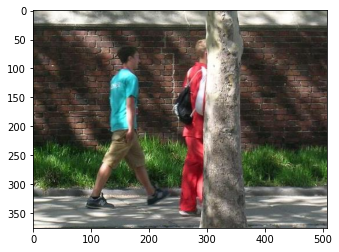

In [17]:
plt.imshow(img.permute(1,2,0))

Printing the prediction shows that we have a list of dictionaries. Each element of the list corresponds to a different image. As we have a single image, there is a single dictionary in the list.
The dictionary contains the predictions for the image we passed. In this case, we can see that it contains `boxes`, `labels`, `masks` and `scores` as fields.

In [18]:
prediction

[{'boxes': tensor([[ 69.0792, 337.3238,  77.4053, 345.2252],
          [191.2553, 347.8951, 201.4672, 357.9696],
          [ 65.3868,  36.3075,  73.8271,  43.6033],
          [266.2959, 294.2975, 279.0556, 306.7942],
          [233.4225, 360.6817, 244.6392, 371.0619],
          [264.9593, 194.6720, 277.2647, 206.6647],
          [ 80.3236, 164.2897,  87.9731, 173.3562],
          [145.0444, 216.8720, 155.8703, 226.3516],
          [233.1312, 362.1373, 242.1087, 368.7317],
          [313.1992, 310.8540, 320.7054, 321.1306],
          [ 72.8600, 204.9577,  83.3109, 213.1965],
          [ 15.7798,  61.6303,  28.5761,  72.1055],
          [353.1883, 320.1796, 364.5693, 333.9596],
          [ 15.7791, 123.1141,  26.4921, 132.9198],
          [365.7875, 181.7279, 376.9590, 192.5107],
          [359.4249,  75.0934, 371.2367,  87.1161],
          [315.3518, 350.6753, 326.3675, 361.1568],
          [301.4643,  25.7247, 307.4501,  37.5869],
          [192.4285, 122.0240, 205.8594, 132.6603],
   

Let's inspect the image and the predicted segmentation masks.

For that, we need to convert the image, which has been rescaled to 0-1 and had the channels flipped so that we have it in `[C, H, W]` format.

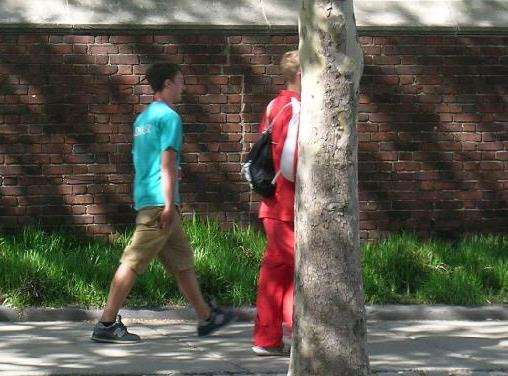

In [19]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

And let's now visualize the top predicted segmentation mask. The masks are predicted as `[N, 1, H, W]`, where `N` is the number of predictions, and are probability maps between 0-1.

In [ ]:
for i in range(prediction[0]['masks'].shape[0]):
  mask = prediction[0]['masks'][i].permute(1,2,0).to('cpu')
  plt.imshow(mask.reshape(mask.shape[0],mask.shape[1]))
  plt.show()